# Business Challenge III - Team 2

Lorena Cruz, Raffaella Ambrosio, Ella Ponti, Jasraj Kaur Gill, Pramanya Guda

# Introduction

Puerto Rico faced a massive disaster when Hurricane María hit on September 6, 2017. This extremely powerful category 4 storm was one of the strongest to ever strike the Atlantic, causing massive damage. Just as the island was trying to recover from another hurricane, Irma, María made things worse by knocking out power for everyone, damaging weather monitoring equipment, and leading to widespread flooding. This had a long-term negative effect on the island.

In collaboration with EY, our team analysed high-resolution satellite images captured before and after Hurricane Maria through Maxar GeoEye-1 to identify damaged areas within San Juan, Puerto Rico. We began by selecting the most distinct and detailed images for image annotation through LabelMe. This crucial process of tagging images within specific datasets aids in developing machine learning models. In this case, we identified commercial and residential buildings and identified the damages. This study aims to look into how Hurricane María impacted Puerto Rico by using data from the Sentinel-2 satellite, spotting specific objects, and creating models. We want to understand why some areas suffered more than others and come up with useful advice for handling disasters better in the future. The study will be done carefully to make sure our conclusions are solid and trustworthy. 

Our goal for the project is to create a model that can accurately predict which residential and commercial areas incurred damage from Hurricane Maria for the potential future use case of providing emergency relief and to anticipate where future disasters would occur if another Hurricane were to hit again. 

# Package Installation and Imports


In [1]:
## Package Installations ##

#pip install ultralytics
#pip install opencv-python-headless
#pip install labelme2yolo
#%pip install gdal
#%pip install osgeo

In [2]:
## Loading Libraries##

# supressing warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff images
import rasterio
from   osgeo import gdal

# data visualisation
from   matplotlib        import pyplot as plt
from   matplotlib.pyplot import figure
import matplotlib.image  as img
from   PIL               import Image

# model building
import ultralytics
from   ultralytics import YOLO
import labelme2yolo

# others
import os
import shutil
import zipfile

# import common GIS tools
import numpy                   as np
import xarray                  as xr
import matplotlib.pyplot       as plt
import rasterio.features
import rioxarray               as rio
from matplotlib.cm import RdYlGn, Reds

# import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load

# additional libraries
from datetime import date

%matplotlib inline

In [3]:
# paths to event images
pre_event_image = './Post_Event_San_Juan.tif'
post_event_image ='./Pre_Event_San_Juan.tif'

# Analyzing areas that are most affected 

In [4]:
## Hurricane Maria - San Juan, Puerto Rico ##

# defining the bounding box for the entire data region 
min_lon = -66.19385887
min_lat =  18.27306794
max_lon = -66.08007533
max_lat =  18.48024350

# setting geographic boundary
bounds = (min_lon, min_lat, max_lon, max_lat)

# setting time window
time_window = "2017-04-01/2018-01-01"

In [5]:
# calculating days in time window
print(date(2018, 1, 1) - date(2017, 4, 1 ))

275 days, 0:00:00


In [6]:
# connecting to the planetary computer
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")


# searching for data
search = stac.search(collections = ["sentinel-2-l2a"],
                     bbox        = bounds,
                     datetime    = time_window)


# instantiating results list
items = list(search.get_all_items())


# summarizing results
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 85


In [7]:
# checking individual results
for item in items[0:5]:
    print(item)

<Item id=S2B_MSIL2A_20171229T150709_R082_T19QHA_20201014T171652>
<Item id=S2B_MSIL2A_20171229T150709_R082_T19QGA_20201014T171649>
<Item id=S2A_MSIL2A_20171224T150711_R082_T19QHA_20201014T160213>
<Item id=S2A_MSIL2A_20171224T150711_R082_T19QGA_20201014T160212>
<Item id=S2B_MSIL2A_20171219T150709_R082_T19QHA_20201014T151203>


In [8]:
# pixel resolution for the final product
resolution = 10  # meters per pixel 


# scaling to degrees per pixel
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

In [9]:
xx = stac_load(
    items,
    bands      = ["red", "green", "blue", "nir", "SCL"],
    crs        = "EPSG:4326",                            # latitude-longitude
    resolution = scale,                                  # degrees
    chunks     = {"x": 2048, "y": 2048},
    dtype      = "uint16",
    patch_url  = pc.sign,
    bbox       = bounds
)

In [10]:
date_photo_1 = xx.time.isel(time = 0).dt.strftime("%Y-%m-%d").item()
date_photo_2 = xx.time.isel(time = 29).dt.strftime("%Y-%m-%d").item()
date_photo_3 = xx.time.isel(time = 39).dt.strftime("%Y-%m-%d").item()

print(date_photo_1)
print(date_photo_2)
print(date_photo_3)

2017-04-08
2017-10-15
2017-12-09


In [11]:
# view the dimensions of our XARRAY and the variables
display(xx)

<xarray.Dataset>
Dimensions:      (latitude: 2308, longitude: 1268, time: 44)
Coordinates:
  * latitude     (latitude) float64 18.48 18.48 18.48 ... 18.27 18.27 18.27
  * longitude    (longitude) float64 -66.19 -66.19 -66.19 ... -66.08 -66.08
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2017-04-08T15:07:21.026000 ... 2017-12...
Data variables:
    red          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 2048, 1268), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 dask.array<chunksize=(1, 2048, 1268), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 dask.array<chunksize=(1, 2048, 1268), meta=np.ndarray>
    nir          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 2048, 1268), meta=np.ndarray>
    SCL          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 2048, 1268), meta=np.ndarray>

In [12]:
# select a time slice to view a single RGB image and the cloud mask
time_slice_photo_1 = 0 # April 8, 2017 (pre-storm)

time_slice_photo_2 = 29 # October 15, 2017 (approximately 2 weeks post-storm)

time_slice_photo_3 = 39 # December 9, 2017 (approximately 3 months post-storm)

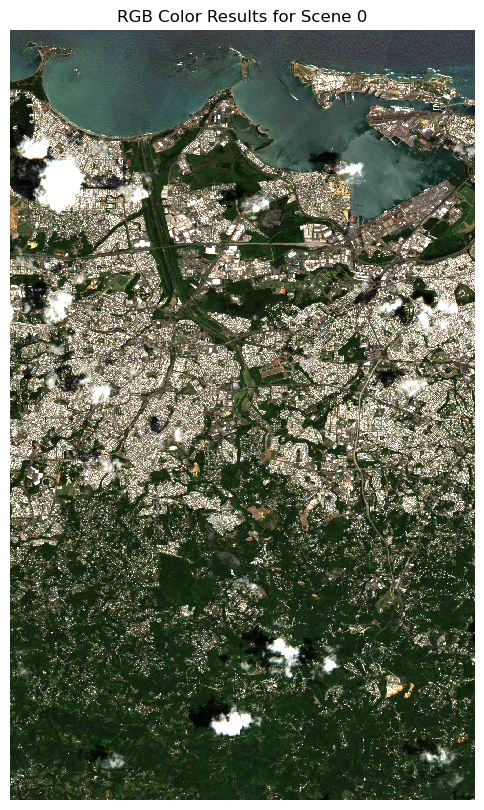

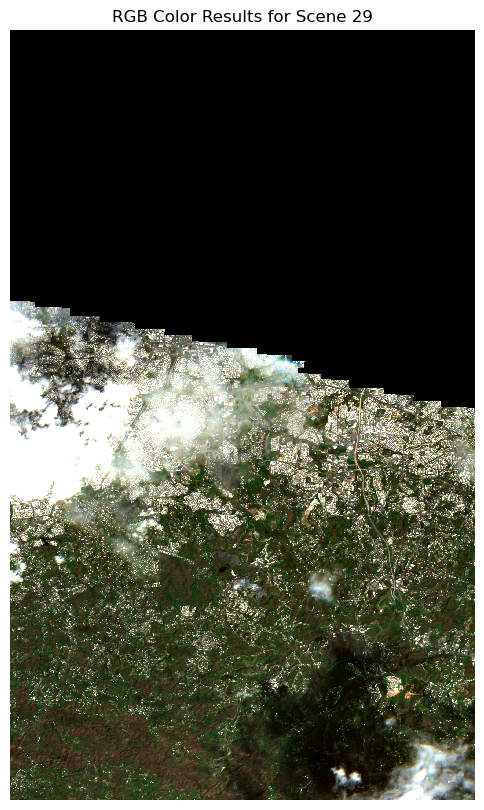

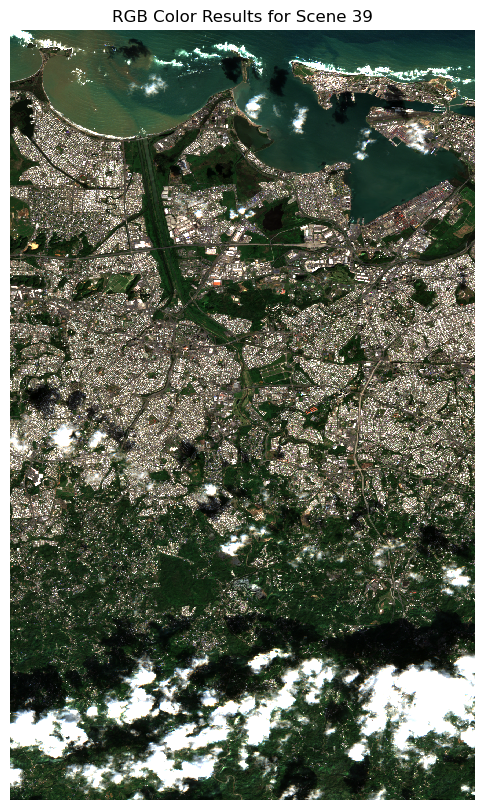

In [13]:
# plotting an RGB real color image for a single date
# setting plot size
fig, ax = plt.subplots( figsize = (6, 10) )

# preparing the plot
xx.isel(time = time_slice_photo_1)[ ["red", "green", "blue"] ].\
    to_array().plot.imshow(robust = True,
                           ax     = ax  ,
                           vmin   = 0   ,
                           vmax   = 3000)

# titles and axis lables
ax.set_title(label = f"RGB Color Results for Scene {time_slice_photo_1}")
ax.axis('off')

# rendering results
plt.show()


# setting plot size
fig, ax = plt.subplots( figsize = (6, 10) )

# preparing the plot
xx.isel(time = time_slice_photo_2)[ ["red", "green", "blue"] ].\
    to_array().plot.imshow(robust = True,
                           ax     = ax  ,
                           vmin   = 0   ,
                           vmax   = 3000)

# titles and axis lables
ax.set_title(label = f"RGB Color Results for Scene {time_slice_photo_2}")
ax.axis('off')

# rendering results
plt.show()

# setting plot size
fig, ax = plt.subplots( figsize = (6, 10) )

# preparing the plot
xx.isel(time = time_slice_photo_3)[ ["red", "green", "blue"] ].\
    to_array().plot.imshow(robust = True,
                           ax     = ax  ,
                           vmin   = 0   ,
                           vmax   = 3000)

# titles and axis lables
ax.set_title(label = f"RGB Color Results for Scene {time_slice_photo_3}")
ax.axis('off')

# rendering results
plt.show()

# Pre- and Post-Event NDVI Analysis


In [14]:
# instantiating a colormap for SCL pixel classifications
scl_colormap = np.array(
    [
        [252,  40, 228, 255],  # 0  - NODATA - MAGENTA
        [255,   0,   4, 255],  # 1  - Saturated or Defective - RED
        [0  ,   0,   0, 255],  # 2  - Dark Areas - BLACK
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow - DARK GREY
        [3  , 139,  80, 255],  # 4  - Vegetation - GREEN
        [192, 132,  12, 255],  # 5  - Bare Ground - BROWN
        [21 , 103, 141, 255],  # 6  - Water - BLUE
        [117,   0,  27, 255],  # 7  - Unclassified - MAROON
        [208, 208, 208, 255],  # 8  - Cloud - LIGHT GREY
        [244, 244, 244, 255],  # 9  - Definitely Cloud - WHITE
        [195, 231, 240, 255],  # 10 - Thin Cloud - LIGHT BLUE
        [222, 157, 204, 255],  # 11 - Snow or Ice - PINK
    ],
    dtype="uint8",
)

In [15]:
# function for color encoding
def colorize(xx, colormap):
    return xr.DataArray( colormap[xx.data],
                         coords = xx.coords,
                         dims   = (*xx.dims, "band") )

In [16]:
# filtering out water, etc.
filter_values = [0, 1, 3, 6, 8, 9, 10]

cloud_mask = ~xx.SCL.isin(filter_values)

In [17]:
# appling cloud mask (filtering out clouds, cloud shadows, and water)
# storing as 16-bit integers
cleaned_data = xx.where(cloud_mask).astype("uint16")

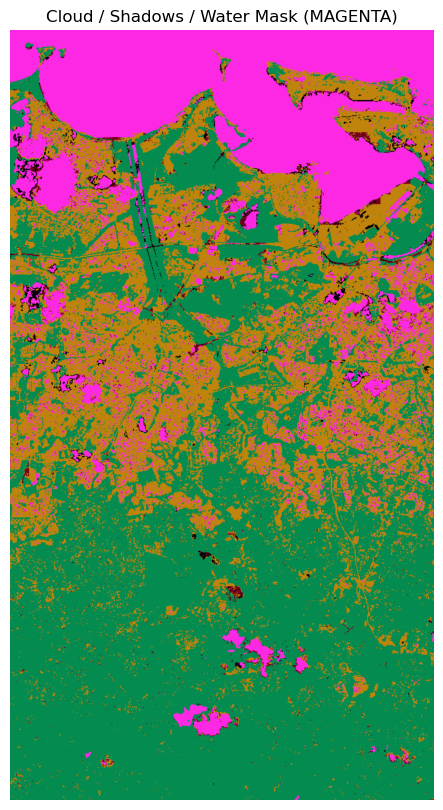

In [18]:
# converting SCL to RGB
scl_rgba_clean = colorize(xx       = cleaned_data.isel(time = time_slice_photo_1).SCL.compute(), 
                          colormap = scl_colormap)


# setting figure size
plt.figure(figsize = (6, 10))
plt.imshow(scl_rgba_clean)


# titles and axis labels
plt.title(label = "Cloud / Shadows / Water Mask (MAGENTA)")
plt.axis('off')


# rendering the plot
plt.show()

The image showcased here uses satellite imagery to examine the destruction caused by Hurricane María, we are Cloud Masking here, emphasizing the removal of interference from clouds, shadows, or water bodies. These are represented by the magenta color, indicating areas that have been filtered out to provide a more transparent view of the damage. This method is vital as it significantly improves the assessment of land conditions by eliminating visual barriers. It's a key step in ensuring effective disaster management and recovery efforts. By filtering out these elements, the clarity and precision of satellite images are greatly enhanced, which is crucial for a detailed analysis and comprehension of the damage inflicted by natural disasters such as hurricanes.

In [19]:
# preparing two time steps compare NDVI outputs
first_time_comparison_1  = 0  # April 8, 2017
second_time_comparison_1 = 29 # October 9, 2017

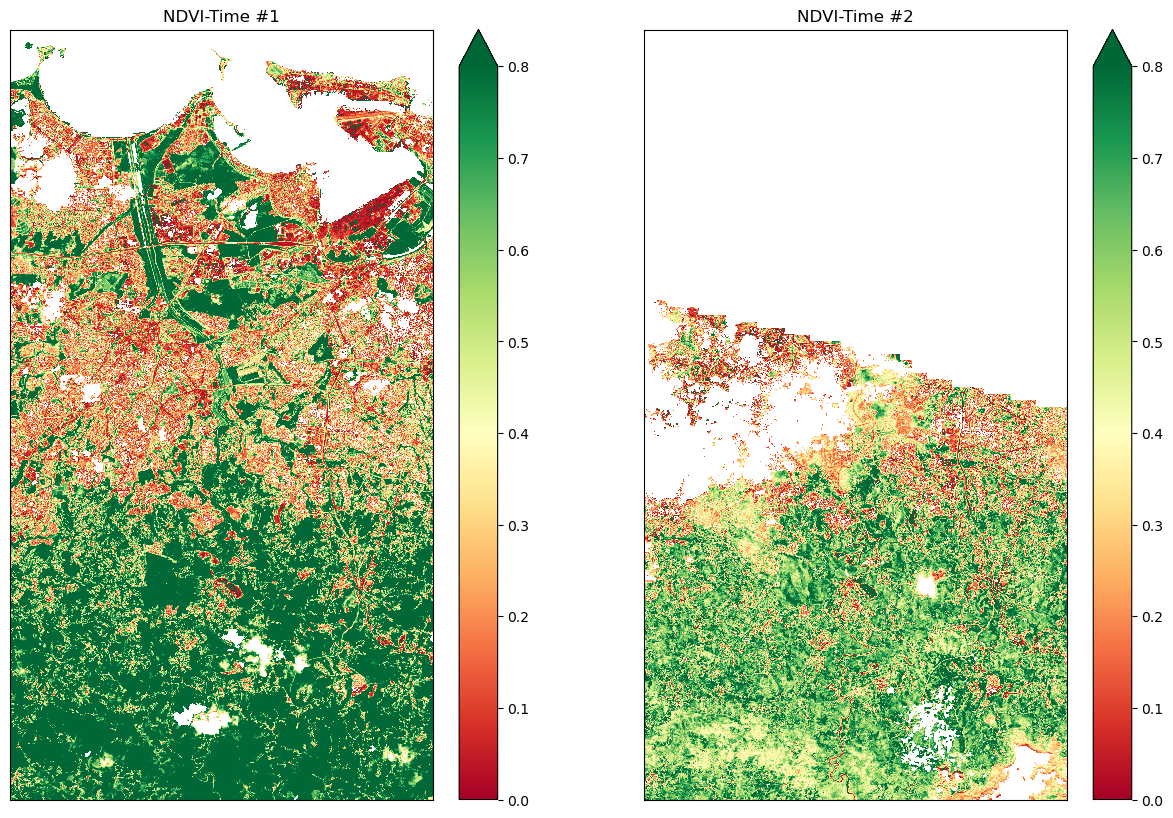

In [20]:
# plots of NDVI at two different time slices
# setting figure size
fig, ax = plt.subplots(1, 2, figsize = (15, 10))

# first image data
ndvi_image_1 = (cleaned_data.nir - cleaned_data.red) / (cleaned_data.nir + cleaned_data.red)
ndvi_image_1.isel(time = first_time_comparison_1 ).plot(ax = ax[0],
                                                     vmin = 0.0,
                                                     vmax = 0.8,
                                                     cmap = "RdYlGn")
# second image data
ndvi_image_1.isel(time = second_time_comparison_1).plot(ax = ax[1],
                                                      vmin = 0.0,
                                                      vmax = 0.8,
                                                      cmap = "RdYlGn")

# axis labels
ax[0].set_title(label = 'NDVI-Time #1'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title(label = 'NDVI-Time #2'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)

# rendering the plot
plt.show()

### NDVI Analysis of the Surrounding Pre and Post Storm

The images we're looking at aim to shed light on how vegetation health and coverage have changed over time, especially in response to extreme weather events. We've used two sets of data from the Normalized Difference Vegetation Index (NDVI) taken on April 8, 2017, and October 9, 2017, to conduct this analysis. These dates are significant because they allow us to see the state of vegetation before and after a major storm hit. However, it's crucial to acknowledge that vegetation health is influenced by a myriad of factors beyond just weather events. Variables such as the types of plants in the area, soil conditions, and local climate patterns play a significant role in the health and coverage of vegetation. To truly understand what's happening with the vegetation, it's important to look at these factors in conjunction with NDVI data.

The data from April 8, 2017, is rich in green hues, signaling robust vegetation health. This coloration points to favorable growing conditions at the time, suggesting that the plants were thriving. Fast forward to October 9, 2017, and the scene shifts dramatically. There's a noticeable increase in red areas in the output, signaling a downturn in vegetation health or a decrease in coverage. This change is attributed to the environmental aftermath of a hurricane that swept through Puerto Rico, leaving destruction in its wake. For a more rounded analysis, future research should look at combining NDVI trends with on-the-ground observations and other forms of remote sensing data. Doing so would allow for a more accurate validation and calibration of the NDVI data, paving the way for the development of robust models capable of predicting changes in vegetation health and coverage. Through such detailed analysis, NDVI data becomes a powerful tool in enhancing our grasp of vegetation dynamics and promoting practices that support sustainable land management.

# Visualizing GeoTiFF Images

In [21]:
# function to open a geotiff file
def load_and_visualize(image_path):
    with rasterio.open(image_path) as src:
        # read the red, green and blue bands
        red   = src.read(1)
        green = src.read(2)
        blue  = src.read(3)
    # Plot the bands
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    ax1.imshow(red,cmap='Reds')
    ax1.set_title('Red Band')
    ax2.imshow(green, cmap='Greens')
    ax2.set_title('Green Band')
    ax3.imshow(blue, cmap='Blues')
    ax3.set_title('Blue Band')
plt.show()

In [ ]:
# pre-event image
load_and_visualize(pre_event_image)

In [ ]:
# post-event image
load_and_visualize(post_event_image)

# Labeling the photos and preparing the dataset

Our team will analyze the photos with the following options to distingish between residential and commercial buildings. 
Furthermore, buildings are analyzed for damage. During the labeling process we will use the following labels.

<table>
  <tr>
    <th>Object</th>
    <th>Naming Convention</th>
  </tr>
  <tr>
    <td>Undamaged Residential Building</td>
    <td>undamagedresidentialbuilding</td>
  </tr>
  <tr>
    <td>Damaged Residential Building</td>
    <td>damagedresidentialbuilding</td>
  </tr>
   <tr>
    <td>Undamaged Commercial Building</td>
    <td>undamagedcommercialbuilding</td>
  </tr>
     <tr>
    <td>Damaged Commercial Building</td>
    <td>damagedcommercialbuilding</td>
  </tr>
</table>


In [26]:
#!labelme2yolo --json_dir /path/to/labelme_json_dir/
!labelme2yolo --json_dir "./Json"

INFO:labelme2yolo:Searching label list from json files ...
INFO:labelme2yolo:Converting train set ...
Converting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00m 0:00:01
INFO:labelme2yolo:Converting val set ...
Converting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00m 0:00:01
INFO:labelme2yolo:Converting test set ...
Converting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--


# Building and training the model

In [24]:
#Loading the model
model = YOLO('yolov8n.pt')
# Display model information (optional)
model.info()

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [27]:
# Train the model on the dataset for 50 epochs
results = model.train(data   = "/Users/pramanyaguda/Downloads/Json/YOLODataset/dataset.yaml", # change this as needed
                      epochs = 50  ,
                      imgsz  = 512)

New https://pypi.org/project/ultralytics/8.1.45 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.36 🚀 Python-3.11.8 torch-2.2.2 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/pramanyaguda/Downloads/Json/YOLODataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train73, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

train: Scanning /Users/pramanyaguda/Downloads/Json/YOLODataset/labels/train... 7

train: New cache created: /Users/pramanyaguda/Downloads/Json/YOLODataset/labels/train.cache



val: Scanning /Users/pramanyaguda/Downloads/Json/YOLODataset/labels/val... 18 im

val: New cache created: /Users/pramanyaguda/Downloads/Json/YOLODataset/labels/val.cache
Plotting labels to runs/detect/train73/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/train73
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.067      1.699      1.089         83        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.217      0.342      0.269      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.076      1.677      1.057        111        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.214      0.384      0.255      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.031      1.672      1.065         62        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.225      0.302      0.265      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G          1      1.631      1.055         52        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123       0.25      0.338      0.286      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.078      1.613      1.059         83        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.263       0.48      0.306      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G       1.01      1.503      1.032         78        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.263      0.514      0.291      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.071      1.599      1.054         66        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.267      0.545      0.292      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.059      1.602      1.055         79        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.277      0.516      0.319      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.037      1.612      1.059         69        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.271      0.431      0.309      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.008      1.527       1.04         94        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.293      0.396      0.312      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.9867      1.523      1.025         58        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.238      0.389      0.272      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.015      1.525       1.04         68        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123       0.21      0.478       0.26      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.9492      1.467      1.017         78        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.209      0.457      0.271      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.018      1.526      1.024        103        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.225      0.408      0.274       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.059      1.439      1.061         82        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.278       0.38      0.262       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.046      1.556      1.083         94        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.292      0.392      0.274      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.9953      1.366      1.024         68        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.188      0.503      0.259      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.9971      1.483      1.035         55        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.181      0.485      0.246      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G       1.05      1.388      1.026         59        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.174      0.449      0.253      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.021      1.428      1.047         78        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.237      0.468      0.278      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.9957      1.524      1.027         60        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.308      0.391        0.3      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.9639      1.384       1.01         87        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.283      0.482      0.334      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.081       1.45      1.055         75        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.295      0.497      0.371      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.041      1.403      1.045         60        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.391      0.393      0.387      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.071      1.427      1.089         72        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.378      0.441      0.382      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      0.995      1.362      1.022         88        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.312       0.43      0.344      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.9816      1.351      1.015         82        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.243      0.507      0.309        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.9971       1.29      1.026         80        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.212      0.472      0.259      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.9852      1.298      1.037        106        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.215      0.482      0.265      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      0.984       1.27      1.022        112        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.294      0.432      0.287      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.9672      1.248      1.026         58        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.278      0.492      0.293      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.9686      1.316      1.028        115        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.252      0.459      0.295      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.9603      1.165      1.026         89        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.244      0.436      0.309      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      0.952      1.247      1.027        102        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.335      0.384      0.294      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.9579      1.182      1.016         72        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.343      0.352      0.299      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.9259      1.196     0.9929         80        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.331      0.457      0.317      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.9117      1.211       1.01         73        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.321      0.459      0.319      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.9535      1.178      1.015         79        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.385      0.345      0.327      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.9268      1.199       1.01         94        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.382      0.382      0.328      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.9341      1.145      1.028         71        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.317      0.527      0.334      0.217


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.8942       1.23      1.019         36        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.297      0.514       0.34      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.8916      1.238      1.007         23        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123       0.38       0.42      0.353      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.9177      1.139     0.9992         55        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.405      0.465      0.358      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.9127      1.124     0.9998         46        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.398      0.454      0.357      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.8937      1.166     0.9803         40        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.381      0.498       0.35      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.8241      1.039     0.9675         36        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.423      0.464      0.346      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.8668      1.081     0.9937         43        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.387      0.446      0.362       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.8621      1.019     0.9724         83        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.347      0.446      0.344      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.8355      1.069     0.9609        107        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.359      0.451      0.345      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.8202      1.067      0.979         32        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         18        123      0.354      0.424      0.344      0.226



50 epochs completed in 0.379 hours.
Optimizer stripped from runs/detect/train73/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train73/weights/best.pt, 6.2MB

Validating runs/detect/train73/weights/best.pt...
Ultralytics YOLOv8.1.36 🚀 Python-3.11.8 torch-2.2.2 CPU (Apple M1)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         18        123      0.382      0.445      0.381      0.246
damagedresidentialbuilding         18         16      0.384      0.438       0.39      0.236
undamagedcommercialbuilding         18         49      0.435      0.429      0.428      0.249
damagedcommercialbuilding         18         38      0.495      0.464       0.48      0.342
undamagedresidentialbuilding         18         20      0.215       0.45      0.225      0.159
Speed: 0.9ms preprocess, 134.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/train73


# Model Evaluation

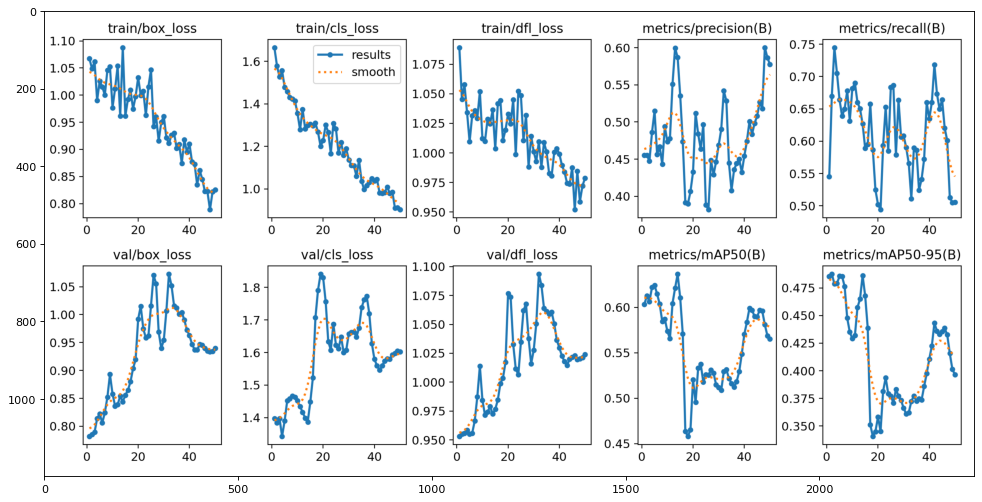

In [28]:
figure(figsize=(15, 10), dpi=80)
# reading the image 
results = img.imread('./runs/detect/train71/results.png') # change this as needed
# displaying the image 
plt.imshow(results) 
plt.show()

<h4>Performance Overiew:</h4>

The image depicts various metrics from a computer vision machine learning project over multiple epochs, indicative of the model's performance during its training and validation phases. It includes plots for the training and validation loss components: box loss, classification loss, and 'df1_loss', which could refer to a specific type of loss function used in object detection. The smooth lines represent the moving average, which shows the overall trend by reducing noise in the data. 

Additionally, the plots for precision and recall for class 'B', as well as the mean Average Precision (mAP) at different Intersection over Union (IoU) thresholds ('mAP50' and 'mAP50-95'), are performance metrics specific to object detection tasks. These metrics give insights into the accuracy of the bounding boxes predicted by the model and the model's capability to correctly classify objects. Overall, the decreasing loss values and the trends in precision, recall, and mAP suggest that the model's ability to detect and classify objects is improving as training progresses.

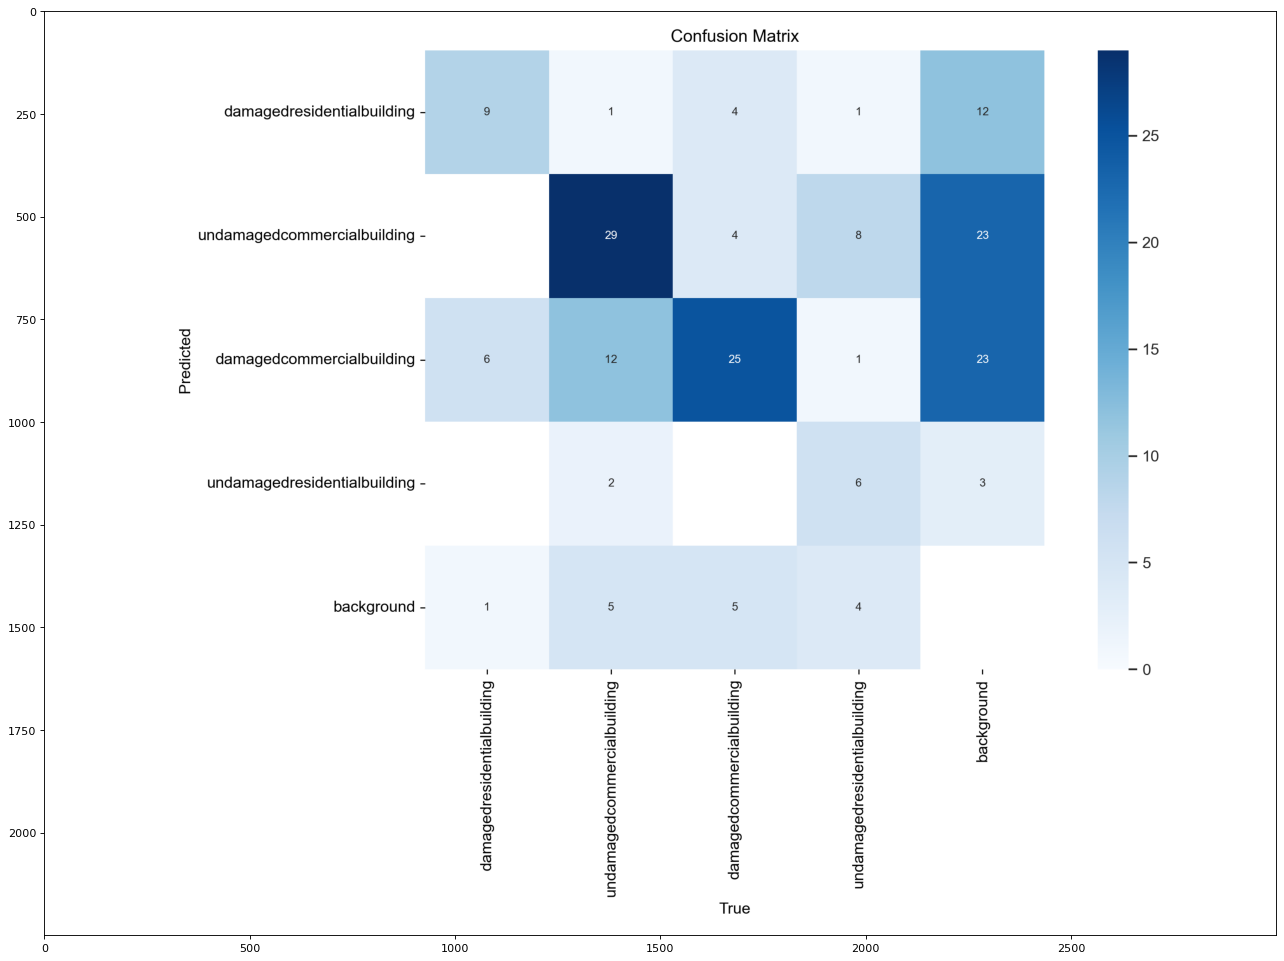

In [29]:
figure(figsize = (20,15),dpi = 80)
cf = img.imread('./runs/detect/train71/confusion_matrix.png')
plt.imshow(cf)
plt.show()

<h4>Confusion Matrix:</h4>

The confusion matrix illustrates the classification accuracy of a model in categorizing images into five distinct groups: damaged residential buildings, undamaged commercial buildings, damaged commercial buildings, undamaged residential buildings, and background.From the matrix, we observe a strong performance in recognizing undamaged commercial buildings with a prominent dark blue square denoting 29 correct identifications. Nevertheless, the model struggles with accurately categorizing damaged commercial buildings, with a considerable number, 25, being wrongly classified as undamaged commercial buildings.

Moreover, the model frequently confuses damaged residential buildings with background, as shown by the 12 instances mislabeled. This misclassification issue is pervasive and significantly detracts from the model's precision. Enhancing the model's ability to discern between various building states, particularly in differentiating damage levels, is critical for improving its overall classification capabilities.

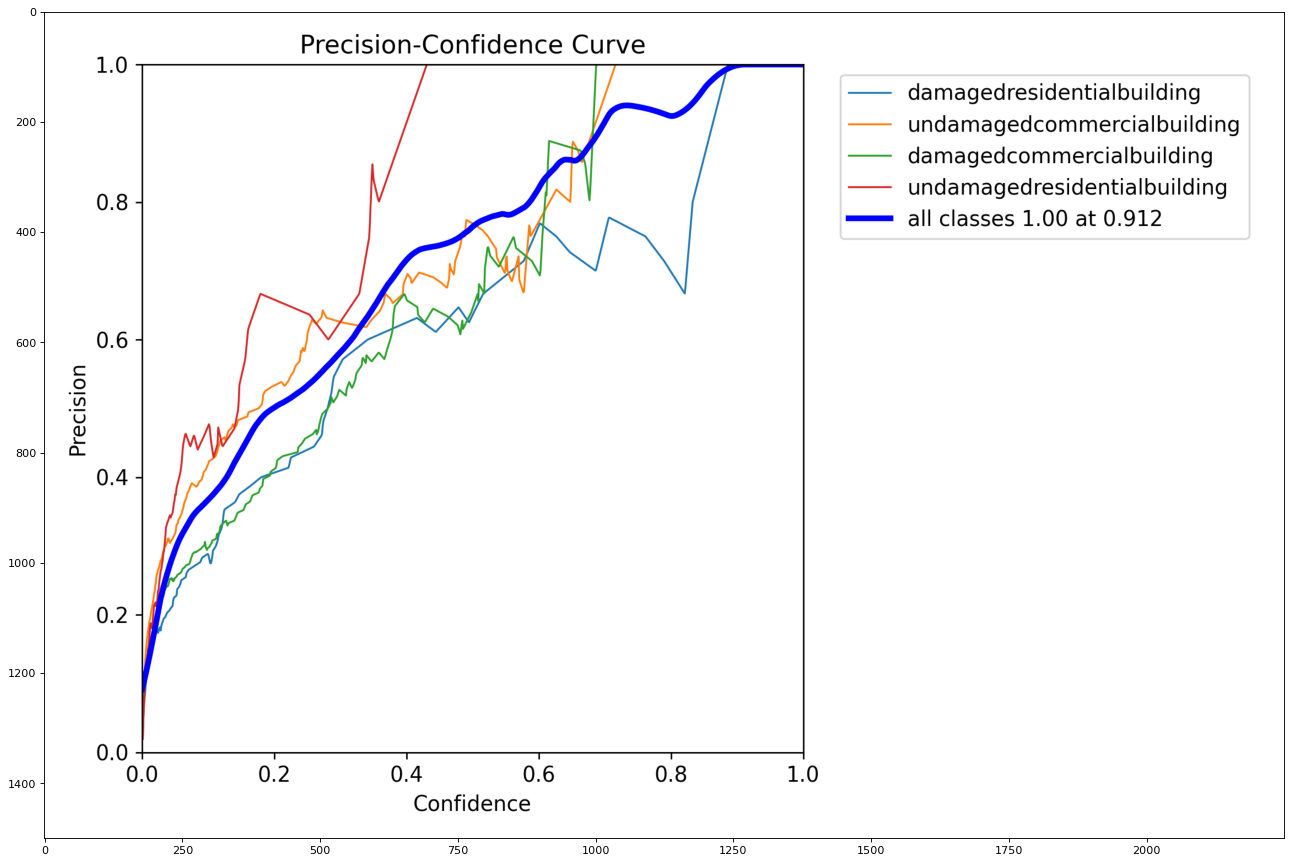

In [30]:
figure(figsize=(20,15), dpi=80)  
# reading the image 
cf = img.imread('./runs/detect/train71/P_curve.png') # change this as needed
# displaying the image 
plt.imshow(cf) 
plt.show()

<h4>Precision-Confidence Curve:</h4>

The Precision-Confidence Curve provides an analytical portrayal of the model's precision across various levels of confidence for different building categories. The curve for undamaged residential buildings, delineated by the red line, exhibits a notably high precision across the entire range of confidence, indicating the model's strong accuracy in this specific classification. However, the precision for damaged residential buildings, represented by the blue line, starts lower and varies more with confidence, suggesting less reliability in the model's predictions for this class. The performance on undamaged commercial buildings and damaged commercial buildings, illustrated by the orange and green lines respectively, indicates a mixed level of precision across confidence levels. Both classes demonstrate fluctuating precision, with damaged commercial buildings generally having a lower precision than undamaged ones, particularly at higher confidence levels.

The thick blue line indicates the model's overall precision across all classes combined, achieving a maximum of 1.00 precision at a high confidence level of 0.912. This suggests that when the model is highly confident in its predictions, it is highly precise across all categories. Nevertheless, considering the variability in precision at different confidence levels for individual classes, the aggregated precision across all classes can be misleading. It's important for the model to maintain high precision across a wide range of confidence levels for all individual classes to ensure robust overall performance.

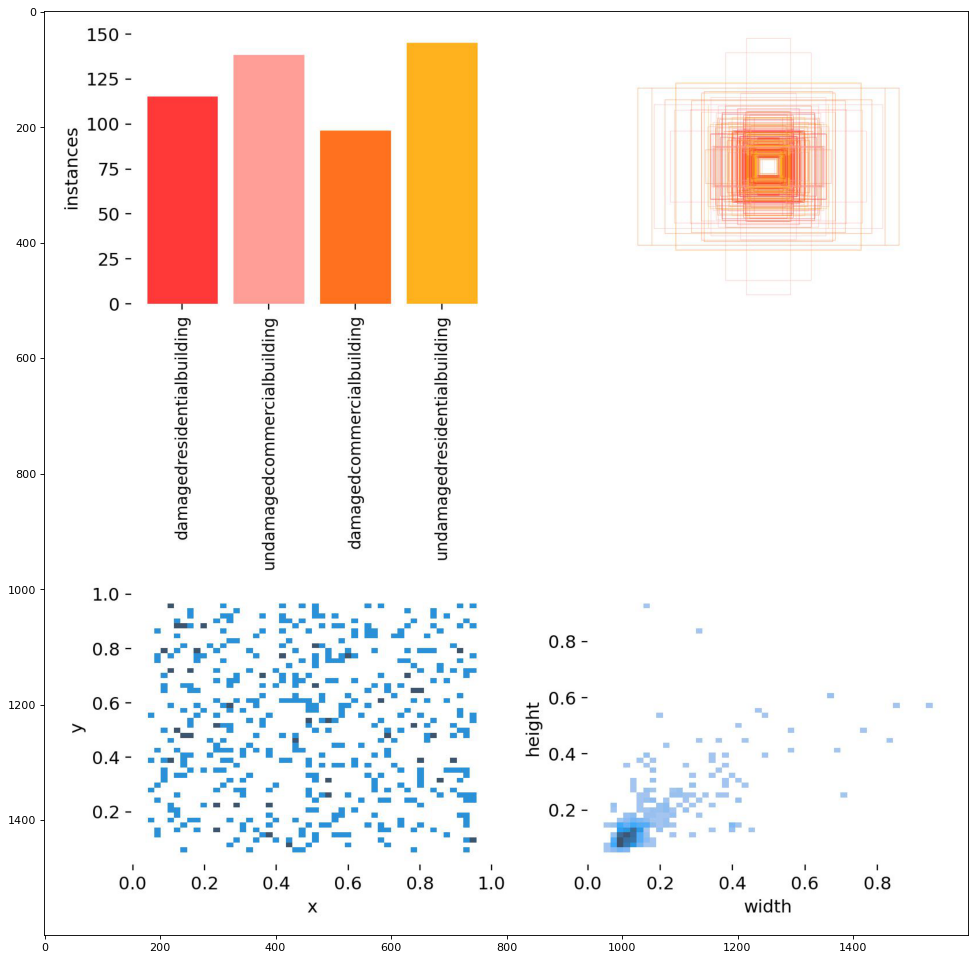

In [31]:
figure(figsize=(20,15), dpi=80)  
# reading the image 
labels = img.imread('./runs/detect/train71/labels.jpg') # change this as needed
# displaying the image 
plt.imshow(labels) 
plt.show()

<h4>Model Details Analysis</h4>

The provided visualizations offer a multifaceted analysis of a dataset used for a building classification model. The first bar chart showcases the distribution of instances across four categories: damaged residential buildings, undamaged commercial buildings, damaged commercial buildings, and undamaged residential buildings. There is a noticeable imbalance, with undamaged residential buildings appearing most frequently and damaged commercial buildings the least. This could potentially skew the model's learning process, resulting in bias towards the more prevalent classes.

The second graph, seemingly a center point localization scatter plot, plots the normalized center coordinates (x, y) of the bounding boxes for detected buildings. Buildings tend to cluster towards the center of the plot, indicating that many bounding boxes are centrally located within the images. The third graph is a bounding box size scatter plot, with width and height on the x and y axes respectively, normalized between 0 and 1. There's a visible concentration of smaller bounding boxes, as indicated by the darker shade in the lower-left region, likely corresponding to smaller buildings or those farther from the viewpoint.

Together, these visualizations help identify the distribution and characteristics of the buildings within the dataset, which is crucial for understanding model performance and guiding further data collection and model training efforts. These insights suggest that strategies such as class weighting, oversampling the minority class, or collecting more balanced data might be needed to improve model robustness and fairness.

# Preparing a submission file

In [33]:
import zipfile
import os

def unzip_folder(zip_filepath, dest_dir):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    print(f'The zip file {zip_filepath} has been extracted to the directory {dest_dir}')

print(f"Current working directory: {os.getcwd()}")
submission_zip = './challenge_1_submission_images.zip'
submission_directory = './challenge_1_submission_images'
unzip_folder(submission_zip,submission_directory)


Current working directory: /Users/pramanyaguda/Downloads


FileNotFoundError: [Errno 2] No such file or directory: './challenge_1_submission_images.zip'

In [32]:
def unzip_folder(zip_filepath, dest_dir):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    print(f'The zip file {zip_filepath} has been extracted to the directory {dest_dir}')



submission_zip = './challenge_1_submission_images.zip'
submission_directory = './challenge_1_submission_images'
unzip_folder(submission_zip,submission_directory)

FileNotFoundError: [Errno 2] No such file or directory: './challenge_1_submission_images.zip'

In [34]:
# Decoding according to the .yaml file class names order
decoding_of_predictions ={0: 'undamagedcommercialbuilding', 1: 'undamagedresidentialbuilding', 2: 'damagedresidentialbuilding', 3: 'damagedcommercialbuilding'}

directory = './challenge_1_submission_images/challenge_1_submission_images/'
# Directory to store outputs
results_directory = 'Validation_Data_Results'

# Create submission directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the current object is a file and ends with .jpeg
    if os.path.isfile(os.path.join(directory, filename)) and filename.lower().endswith('.jpg'):
        # Perform operations on the file
        file_path = os.path.join(directory, filename)
        print(file_path)
        print("Making a prediction on ", filename)
        results = model.predict(file_path, save=True, iou=0.5, save_txt=True, conf=0.25)
        
        for r in results:
            conf_list = r.boxes.conf.numpy().tolist()
            clss_list = r.boxes.cls.numpy().tolist()
            original_list = clss_list
            updated_list = []
            for element in original_list:
                 updated_list.append(decoding_of_predictions[int(element)])

        bounding_boxes = r.boxes.xyxy.numpy()
        confidences = conf_list
        class_names = updated_list

        # Check if bounding boxes, confidences and class names match
        if len(bounding_boxes) != len(confidences) or len(bounding_boxes) != len(class_names):
            print("Error: Number of bounding boxes, confidences, and class names should be the same.")
            continue
        text_file_name = os.path.splitext(filename)[0]
        # Creating a new .txt file for each image in the submission_directory
        with open(os.path.join(results_directory, f"{text_file_name}.txt"), "w") as file:
            for i in range(len(bounding_boxes)):
                # Get coordinates of each bounding box
                left, top, right, bottom = bounding_boxes[i]
                # Write content to file in desired format
                file.write(f"{class_names[i]} {confidences[i]} {left} {top} {right} {bottom}\n")
        print("Output files generated successfully.")


FileNotFoundError: [Errno 2] No such file or directory: './challenge_1_submission_images/challenge_1_submission_images/'

In [35]:
# Define your source directory and the destination where the zip file will be created
source_dir = results_directory
destination_zip = 'submission'

# Create a zip file from the directory
shutil.make_archive(destination_zip, 'zip', source_dir)

print(f"Directory {source_dir} has been successfully zipped into {destination_zip}.")

Directory Validation_Data_Results has been successfully zipped into submission.


# Analysis questions:


<h4>Actionable Insights:</h4>

In the wake of catastrophic events, it is crucial to direct recovery operations toward commercial areas that have sustained significant damage. Commercial districts are the engines of economic activity, providing employment and essential services that are critical for the sustenance of local economies (UNISDR, 2015). Focusing on these areas is recommended as a primary action point to accelerate economic recovery, reduce financial losses, and diminish the long-term adverse effects of the disaster. This method is in line with established disaster recovery frameworks which highlight the necessity of resource allocation in direct response to the severity of the impact (Cutter, Boruff & Shirley, 2003). Highlighting the importance of Immediate Aid Prioritization, where our data-driven approach enables us to identify and swiftly respond to the most devastated areas. Building on this, we discuss Enhancing Building Resilience by leveraging insights into structural vulnerabilities to inform and revise building codes for future infrastructure resilience.

Simultaneously, it is imperative to concentrate relief and rebuilding efforts on residential districts that have experienced heavy destruction. These neighborhoods often house the most vulnerable populations, and providing swift and effective support is vital for the shelter and comfort of the displaced residents (IFRC, 2010). The reconstruction of residential areas is also critical for the community's psychological healing, fostering a sense of stability and belonging, which is central to the collective recovery process (Norris et al., 2008).

Augmenting these recommendations, our NDVI analysis has singled out regions at particular risk of hurricane impact. We advocate for the adoption of proactive strategies to prevent or lessen the effects of future natural disasters in these high-risk zones. These strategies should include the enforcement of land-use planning, the strengthening of infrastructure, updated building codes, and the creation of green infrastructure, as well as the implementation of community education programs that focus on disaster preparedness, emergency response training, and simulations (Renaud & Sudmeier-Rieux, 2013). Moreover, the establishment of early warning systems and the formulation of integrated disaster risk reduction strategies are essential to bolster community resilience (GFDRR, 2019). By adopting a forward-looking stance, communities can significantly reduce the toll of disasters, ensuring a more durable recovery and fostering a safer environment for the future. Lastly, we underscore the significance of Empowering Communities, engaging and educating them to foster a culture of preparedness and resilience. Together, these insights and recommendations are not just reflections on past events but are a roadmap to a safer, more resilient future for all.

<h4>Analysis:</h4>

Initially, we labelled nearly 300 images and transitioned them into .jpeg files using the LabelMe2Yolo software, which also facilitated the segregation of the dataset into subsets for training and testing. When processing the data, we used the generate_tiles function using grids measuring 512x512. We chose to use a moderate grid size, veering toward smaller for a geographical area, due to the precision benefits. With the dataset architecture in place, we moved on to constructing our analytical model using a YOLOv8 model. For the final evaluation of our model's effectiveness, we used the mean average precision (MAP) score as our measurement standard at 50 epochs. 

In our model's performance overview, we're seeing encouraging trends. Training and validation loss metrics—box, class, and dice loss—are on a downward trajectory, signaling effective learning and generalization. Precision and recall metrics demonstrate a stable balance, crucial for maintaining a high true positive rate while minimizing false positives. The model's mean Average Precision, particularly mAP at IOU thresholds of 50 and 50-95, indicate a strong object detection capability across different levels of detection difficulty. No signs of overfitting have been detected, as evidenced by the close alignment between training and validation loss, ensuring our model is performing well without tailoring too closely to our training data. This solid performance paves the way for the model's deployment in practical applications, where reliable and accurate object detection is critical.

With these initial 300 images, we did not receive a high enough score for it to be considered an acceptable model. To address this, we decided to use a re-label and minimize the size of our data set to 90 images. This is due to the fact that some images were not labelled as precisely as we needed as well as some images being removed due to unclear imaging, such as images with clouds. In our final model, we reached a average MAP score of 0.65. 

Upon evaluating our model performance, we see from our visuals that the model has improved over time as the cls, box, and dfl loss values have decreased over time. The box loss value indicates the accuracy of our model’s predictions, while the cls loss value indicates recognition, and the dfl loss value addresses the issue of class imbalance. Our precision metrics tell us by what percentage our model has correctly identified the images out of our entire data. We see from our recall metrics that there was an initial peak and following decline, which tells us that there has been some fluctuation in our model across epochs. This is not ideal; however, if we were to continue to work on this project, we would make it a priority to address this.

<h4>Conclusion:</h4>

Our team conducted a research and then analyzed on how Hurricane Maria affected the vegetation and structures in Puerto Rico by utilizing satellite imagery and applying machine learning approaches. We started by examining Sentinel-2 satellite images to evaluate the condition of the vegetation before and after the hurricane struck. Subsequently, the images were marked to identify buildings as either damaged or undamaged, noting differences between commercial and residential properties. Lastly, we created a model for detecting and classifying buildings, distinguishing them by their type (either residential or commercial) and the extent of damage incurred.

After completing 50 epochs of training in a model focused on addressing the challenges of hurricane disasters, we observed significant progress and insights into the model's performance and its potential applications. The training, completed in under 2 hours, demonstrated the model's efficiency and the effective use of the Ultralytics YOLOv8 framework on an Apple M1 CPU, showing a good balance of speed and accuracy with 8.1 GFLOPs.

Evaluating the model against the validation dataset provided detailed insights into its performance across different categories. With an overall mAP50 (mean Average Precision at 50% IoU threshold) of 0.638 and precision and recall values of 0.588 and 0.628 respectively, the model shows a balanced capability in detecting and accurately classifying instances within the provided images. This balance is crucial for reliable disaster assessment and aid planning.

Conversely, the model showed lower precision in detecting damaged commercial buildings and undamaged residential buildings. This variance suggests a need for further training or adjustment in these areas to improve the model's reliability across different building types and damage levels.

Therefore, our analysis resulted these three actionable insights:

- Focus on areas with significant commercial damage first to help revive the local economy and restore essential services.
- Apply protective strategies in regions pinpointed by NDVI analysis as susceptible to lessen the impact of upcoming disasters.
- Direct immediate assistance and rebuilding efforts towards residential zones that have suffered severe damage to ensure people have housing.

In conclusion, the model demonstrates promising capabilities in distinguishing between damaged and undamaged buildings, a crucial aspect of assessing hurricane disaster impacts. While showing strong performance in certain categories, there is room for improvement in others, indicating a pathway for further refinement. This work lays a solid foundation for developing tools that can enhance disaster preparedness and response, ultimately contributing to more effective and efficient aid distribution and recovery efforts.


<h4>Implementation and Improvement Steps if Given Three Months:</h4>

From what we learned through trial and error in our project, if we had the chance to do it all over again with three months instead of just one week, we'd change our approach in several key ways.

To begin with, we'd dive into gathering information about the population and layout of Puerto Rico to get a clearer picture of where people live and work across the island. Following that, we'd put together detailed guidelines for labeling, ensuring everyone uses the same standards. We'd also train our team thoroughly to guarantee the consistency and accuracy of the labeled images, addressing the issue of varying interpretations that led to inconsistent data during our initial efforts. 

Moreover, we'd aim to balance our training data better by increasing the representation of each category, particularly those less represented than undamaged residential buildings, which received the highest mAP score. We believe that boosting the numbers for the currently underperforming categories could greatly enhance their precision scores. Additionally, we'd take a closer look at photos taken before and after the event to sharpen our ability to distinguish between damaged and undamaged buildings. This approach, alongside verifying building locations with tools like Google Maps to determine if they're commercial or residential, would greatly increase our dataset's precision. We'd also factor in the size and external features of buildings since these differ between residential and commercial structures. 

With these adjustments, we anticipate overcoming the main issues we encountered with data inconsistency in our initial project and significantly improving our mean Average Precision (mAP50) score.

<h4>References:</h4>

National Hurricane Center and Central Pacific Hurricane Center. (2023). "Post-Tropical Cyclone Tammy Public Advisory." NHC NOAA. https://www.nhc.noaa.gov/text/refresh/MIATCPAT5+shtml/191150.shtml

Sendai Framework for Disaster Risk Reduction 2015-2030. (2015, June 29). Undrr.org. https://www.undrr.org/publication/sendai-framework-disaster-risk-reduction-2015-2030

Cutter, S. L., Boruff, B. J., & W. Lynn Shirley. (2003). Social Vulnerability to Environmental Hazards*. Social Science Quarterly, 84(2), 242–261. https://doi.org/10.1111/1540-6237.8402002

World Disasters Report 2010: Focus on urban risk | IFRC. (2017, December 18). Ifrc.org. https://www.ifrc.org/document/world-disasters-report-2010-focus-urban-risk

Norris, F. H., Stevens, S. P., Pfefferbaum, B., Karen Fraser Wyche, & Pfefferbaum, R. L. (2007). Community Resilience as a Metaphor, Theory, Set of Capacities, and Strategy for Disaster Readiness. American Journal of Community Psychology, 41(1-2), 127–150. https://doi.org/10.1007/s10464-007-9156-6

Hurricanes and Tropical Storms. (2023). Samhsa.gov. https://www.samhsa.gov/find-help/disaster-distress-helpline/disaster-types/hurricanes-tropical-storms

# Feedback for EY

Taking part in this challenge was like stepping into a whole new world of analyzing data, especially with the tricky parts of dealing with messy data and trying to make sense of satellite pictures. We really liked how we could think for ourselves and make our own interpretations. Plus, working on a project that could actually make a difference in the real world gave our work a lot of meaning and made us feel like we were doing something important. It was a big deal for us because it tested our skills and showed us how powerful data science can be in solving actual problems.

Embarking on this challenge also spotlighted the importance of adaptability and creativity in data science. As we navigated through the uncharted territory of satellite imagery, each obstacle became a learning opportunity, pushing us to think outside the box and develop innovative solutions. It was a vivid reminder of how data science is not just about numbers and algorithms, but also about the stories that data can tell and the solutions it can unveil when approached with curiosity and an open mind. Moreover, this experience underlined the significance of effective communication within our team and with stakeholders, as conveying our findings in an understandable and impactful way was crucial to the project's success. This adventure into the realm of data analysis has not only equipped us with invaluable skills but also instilled a lasting enthusiasm for exploring how data can be used to illuminate and tackle even the most daunting challenges.

Although the project was exciting and taught us a lot, there were times when we wished for more guidance, especially as beginners in dealing with satellite images. Figuring out how to label the images properly right at the start was tough, especially with the clock ticking. Having clearer instructions or some examples to follow would have helped us get it right faster and more accurately. If we had more time to work on it, that could have also made things easier.

We're really thankful to Dr. Chase Kusterer and Dr. Brian Killough for letting us be part of this challenge. It was an incredible chance to use what we've learned in a practical setting and stretched us beyond what we've been taught in class. Despite the hurdles, our team agrees that this project was a standout moment in our Master of Science in Business Analytics program at Hult International Business School.